This is a technique I'm experimenting with. Let's say you have a bunch of psychometric data, and you want to figure out which questions correlate together. The goal is to combine them in order to create new factors. What if we tried doing this manually, and let the *data* tell us how many factors we need?

Let's walk through how we might do it.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Responses to a personality test
# Pre-wrangled, because getting it nice and tidy isn't the interesting part here
data = pd.read_csv('Personality_AB5C_prewrangled.csv')
del data['Unnamed: 0']
def absolute_correlations(col, df=data, threshold=.5):
    '''Finds related questions, with both positive and negative correlations'''
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs[corrs.absol > threshold].sort_values('absol', ascending=False).drop('absol', axis=1)

def rev(item):
    '''Questions are scored out of 7, and many need to be reverse-scored'''
    return 8 - item

data.shape

(86, 512)

In [3]:
from random import choice

# 30 sample questions out of 500+ total (no need to see all of them!)
for i in range(30):
    print(choice(data.columns))

imakedemandsonothers
iwouldnevercheatonmytaxes
iamguidedbymymoods
ifinditdifficulttogetdowntowork
iameasilymovedtotears
idontunderstandpeoplewhogetemotional
ithinkquickly
ithinkquickly
ihaveaneyefordetail
idisclosemyintimatethoughts
icantalkothersintodoingthings
ilikemusic
igetaheadstartonothers
itendtofeelthesameeveryday
iwanttobeleftalone
ifeellittleconcernforothers
iremaincalmunderpressure
ineedthingsexplainedonlyonce
iamabletofindoutthingsbymyself
igetaheadstartonothers
iseldomtakeoffense
idontmindbeingthecenterofattention
iseekconflict
iamnotinterestedinotherpeoplesproblems
imeetchallenges
irarelygetcaughtupintheexcitement
isticktotherules
idonotlikeconcerts
igetoverwhelmedbyemotions
ishowmygratitude


Okay, here's the rationale. Let's look at the questions with the highest standard deviations *first*. These controversial ones well probably tell us more about someone than the questions that everyone answers similarly.

In [4]:
# Transpose the dataframe, so we're analyzing questions instead of users
qs = data.select_dtypes(include=[np.number]).fillna(data.mean()).T

qs['stdev'] = qs.std(axis=1)

questions_sorted = qs.sort_values('stdev', ascending=False)['stdev'].index

# Most controversial at top; least controversial at bottom
questions_sorted

Index(['icryduringmovies', 'icryeasily', 'iburstintotears',
       'iameasilymovedtotears', 'iloveagoodfight', 'iwouldntharmafly',
       'itrytooutdoothers', 'idontcallpeoplejusttotalk', 'idonotlikepoetry',
       'idontmindeatingalone',
       ...
       'itakeothersinterestsintoaccount', 'ishowmygratitude',
       'irespecttheprivacyofothers', 'ienjoythebeautyofnature',
       'ilikeharmonyinmylife', 'ilovebeautifulthings',
       'irespectothersfeelings', 'ilikemusic', 'irespectothers',
       'iappreciategoodmanners'],
      dtype='object', length=512)

So apparently there are two types of people in the world: those who cry during movies and those who don't.

On the other hand, just about everyone appreciates good manners!

Here's where things get interesting. We're going to iterate over each question and see if there are at least 3 other questions that have a correlation of ±0.5 (I'd go higher, but we don't have enough data currently).

If there are 3 or more related questions, we'll group them all together and score them from 1-100. As a matter of personal preference, I'll use each question only once. Priority will go to the factor with the highest standard deviation.

In [5]:
from collections import defaultdict

# Record which questions go in each factor
factors = defaultdict(list)

# Use each question only once
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

for question in questions_sorted:
    if question not in questions_used:
        related = absolute_correlations(
            question,
            df=data[[i for i in data.columns if i not in questions_used]],
            threshold=.50
        )        
        if len(related) >= 4:
            for related_question in related.index:
                questions_used.append(related_question)
            factors[question].append(related.index)
            
            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)   

            df_factors[question] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))
            
print('found', str(df_factors.shape[1]), 'personality traits')

found 41 personality traits


We ended up with 41 factors, which isn't far off from the [AB5C personality test](http://ipip.ori.org/newab5ckey.htm) that purports to have 45. So the technique seems to work!

But I think there's a way we can improve this further. Perhaps we should prioritize factors that are orthogonal to the ones we've already discovered. So if the 1st factor is the "cry during movies" factor, the 2nd one should be one that has a near-zero correlation with the 1st.

In [6]:
def uncorrelated(col, df=data, threshold=100):
    '''Similar to absolute_correlations, but now finds uncorrelated items'''
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    
    # Default is to return all items sorted by correlation (ascending)
    return corrs[corrs.absol < threshold].sort_values('absol', ascending=True).drop('absol', axis=1)

In [7]:
from collections import defaultdict

# Record which questions go in each factor
factors = defaultdict(list)

# We're no longer going to worry if a question has been used
# We're now more interested in validity and reliability than style!
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

th = 0.50
lenrel = 4

# Seed the dataframe with the first reliable trait
for question in questions_sorted:
    related = absolute_correlations(
        question,
        df=data,
        threshold=th
    )        
    if len(related) >= lenrel:
        #for related_question in related.index:
            #questions_used.append(related_question)
        factors[question].append(related.index)

        pos_items = related[related['correlation'] > 0].index
        neg_items = related[related['correlation'] < 0].index
        all_items = list(pos_items) + list(neg_items)   

        df_factors[question] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))
        break

df_factors.head()

In [8]:
# So far, so good
df_factors.head()

,icryduringmovies
0,71.429
1,14.286
2,45.714
3,40.000
4,14.286


In [9]:
corr = 0

# Run this until we find a trait that correlates more than 0.3 with an existing one
while corr < .30:
    next_q = data.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in np.abs(next_q).sort_values().index:
        related = absolute_correlations(
            i,
            df=data,
            threshold=th)        
        if len(related) >= lenrel:
            #for related_question in related.index:
                #questions_used.append(related_question)

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            candidates[i] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))

    candidates_scores = {}
    for i in candidates.columns:
        candidates_scores[i] = np.abs(df_factors.corrwith(candidates[i])).max()

    candidates_scores = pd.DataFrame([candidates_scores]).T.sort_values(0)

    print('Using:', pd.DataFrame(candidates_scores).index[0])
    
    corr = candidates_scores.get_value(candidates_scores.index[0], 0)
    print(round(corr, 2))
    
    next_q = data.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in candidates_scores.index:
        related = absolute_correlations(
            i,
            df=data, threshold=th)        
        if len(related) >= lenrel:
            #for related_question in related.index:
                #questions_used.append(related_question)
            factors[i].append(related.index)

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            df_factors[i] = (data[pos_items].sum(axis=1) + (8-data[neg_items]).sum(axis=1))/(.07*len(all_items))    
            break
    if i == candidates_scores.index[-1]:
        raise Exception('Could not find any more traits')
    
    print()

Using: ienjoyspendingtimebymyself
0.0

Using: iamfullofideas
0.02

Using: iignoremyresponsibilities
0.09

Using: iwanttobetoldiamright
0.14

Using: iamnotreallyinterestedinothers
0.18

Using: idisregardrules
0.2

Using: ilookatthebrightsideoflife
0.26

Using: ijokearoundalot
0.29

Using: ispendtimereflectingonthings
0.3

Using: iamopenaboutmyfeelings
0.3



In [10]:
df_factors.head()

,icryduringmovies,ienjoyspendingtimebymyself,iamfullofideas,iignoremyresponsibilities,iwanttobetoldiamright,iamnotreallyinterestedinothers,idisregardrules,ilookatthebrightsideoflife,ijokearoundalot,ispendtimereflectingonthings,iamopenaboutmyfeelings
0,71.429,16.071,45.238,21.429,60.714,25.000,22.857,75.000,57.143,85.714,50.000
1,14.286,82.143,100.000,14.286,82.143,82.143,62.857,67.857,78.571,100.000,82.143
2,45.714,82.143,61.905,21.429,67.857,35.714,48.571,60.714,82.143,88.571,57.143
3,40.000,57.143,64.286,14.286,57.143,42.857,17.143,85.714,57.143,71.429,78.571
4,14.286,62.500,97.619,17.857,32.143,35.714,20.000,89.286,46.429,91.429,53.571


Now let's take a look at the factors we identified:

In [11]:
for num, top in enumerate(factors):
    print(str(num+1)+'. ' + top)
    for list_ in factors[top]:
        for question in list_:
            print('-', question)
    print()

1. icryduringmovies
- icryduringmovies
- iameasilymovedtotears
- icryeasily
- ihavecryingfits
- iburstintotears

2. ienjoyspendingtimebymyself
- ienjoyspendingtimebymyself
- iliketobealone
- iprefertobealone
- ienjoysilence
- iwanttobeleftalone
- iseekquiet
- igomyownway
- idontmindeatingalone

3. iamfullofideas
- iamfullofideas
- iquicklythinkupnewideas
- ihaveexcellentideas
- icantcomeupwithnewideas
- icomeupwithboldplans
- idonothaveagoodimagination

4. iignoremyresponsibilities
- iignoremyresponsibilities
- ineglectmyduties
- iaccomplishmyworkontime
- idonotplanahead

5. iwanttobetoldiamright
- iwanttobetoldiamright
- iwantthingsdonemyway
- ifeelcrushedbysetbacks
- itrytoimpressothers

6. iamnotreallyinterestedinothers
- iamnotreallyinterestedinothers
- iamnotinterestedinotherpeoplesproblems
- iaminterestedinpeople
- itakeaninterestinotherpeopleslives

7. idisregardrules
- idisregardrules
- idontcareaboutrules
- ibreakrules
- itrytofollowtherules
- iopposeauthority

8. ilookatthebr

You'll notice they're sensibly calculated and do indeed seem fairly different from one another!

Now let's do a little housekeeping and rename each trait. I'll use words that best capture the essence of what we're measuring.

In [12]:
df_factors.columns =\
'''sensitivity
enjoyment_of_solitude
ingenuity
irresponsibility
bossiness
self-centeredness
rebeliousness
optimism
joviality
reflectiveness
transparency'''.split('\n')

In [13]:
df_factors.head()

,sensitivity,enjoyment_of_solitude,ingenuity,irresponsibility,bossiness,self-centeredness,rebeliousness,optimism,joviality,reflectiveness,transparency
0,71.429,16.071,45.238,21.429,60.714,25.000,22.857,75.000,57.143,85.714,50.000
1,14.286,82.143,100.000,14.286,82.143,82.143,62.857,67.857,78.571,100.000,82.143
2,45.714,82.143,61.905,21.429,67.857,35.714,48.571,60.714,82.143,88.571,57.143
3,40.000,57.143,64.286,14.286,57.143,42.857,17.143,85.714,57.143,71.429,78.571
4,14.286,62.500,97.619,17.857,32.143,35.714,20.000,89.286,46.429,91.429,53.571


I'm pretty satisfied with these labels, but some of them aren't perfect. For example, I thought of perhaps using "assertiveness" or "dominance" instead of "bossiness," but the former words seemed a bit too positive for a trait that measures whether you "want to be told you're right." 

Before wrapping up, let's take a look at the correlations between the traits we identified.

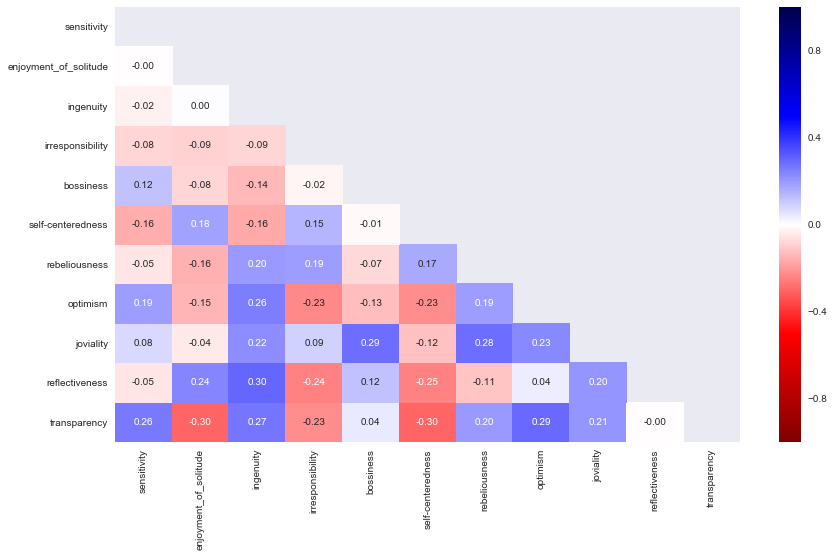

In [14]:
# Generate a mask for the upper triangle
mask = np.zeros_like(df_factors.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Resize and display
plt.figure(figsize=(14,8))
sns.heatmap(df_factors.corr(), annot=True, fmt='.2f', mask=mask, cmap='seismic_r')

I'm really pleased with this! Just as I planned, none of the correlations are above 0.30. These traits are indeed fairly independent of one another!